In [156]:
import subprocess
import os
import av
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import numpy as np
from fractions import Fraction
import csv

In [219]:
def get_total_frames(path: str) -> int:
    p = Path(path)
    if p.is_dir():
        return len([f for f in p.iterdir() if f.is_file()])
    else:
        ffprobe_cmd = [
            "ffprobe",
            "-v", "error",
            "-count_frames",         
            "-select_streams", "v:0",
            "-show_entries", "stream=nb_read_frames",
            "-of", "default=noprint_wrappers=1:nokey=1", 
            path
        ]
        try:
            output = subprocess.check_output(ffprobe_cmd).decode('utf-8')
            return int(output.strip())
        except Exception:
            print("ffprobe failed for file", path)
            return 0 

def get_frame_rate(path: Path) -> Fraction:
    if path.is_dir():
        return Fraction(3)
    cmd = [
        "ffprobe",
        "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "stream=r_frame_rate",
        "-of", "default=noprint_wrappers=1:nokey=1",
        str(path)
    ]
    
    try:
        output = subprocess.check_output(cmd).decode('utf-8').strip()
        return Fraction(output)
    except Exception as e:
        print(f"Error getting frame rate: {e}")
        return Fraction(0)


def get_keyframes_ffmpeg(
    path: str, 
    keyint_min: int = 8, 
    keyint_max: int = 24, 
    sc_threshold: int = 40, 
    bframes: int = -1 # -1 is default, libx264 defaults to 3
) -> tuple[list[int], int, int]:
    tmp_file = "ffmpeg/out.mp4"
    cmd = None
    p = Path(path)
    if p.is_dir():
        cmd = [
        "ffmpeg", 
        "-framerate", "3", # tvqa videos all are at 3 fps
        "-i", p / "%05d.jpg", 
        "-v", "error",
        "-vf", "scale=trunc(iw/2)*2:trunc(ih/2)*2", # Make sure h/w is even
        "-c:v", "libx264", 
        "-g", str(keyint_max), 
        "-keyint_min", str(keyint_min), 
        "-sc_threshold", str(sc_threshold), 
        "-flags", "+cgop", # Use closed GOP to force frames to reference current 
        "-bf", str(bframes),
        tmp_file,
    ]
    else:
        cmd = [
        "ffmpeg", 
        "-v", "error",
        "-i", str(path), 
        "-c:v", "libx264", 
        "-vf", "scale=trunc(iw/2)*2:trunc(ih/2)*2", # Make sure h/w is even
        "-g", str(keyint_max), 
        "-keyint_min", str(keyint_min), 
        "-sc_threshold", str(sc_threshold), 
        "-flags", "+cgop", # Use closed GOP to force frames to reference current 
        "-bf", str(bframes),
        tmp_file,
    ]
    subprocess.check_call(cmd)
    ffprobe_cmd = [
        "ffprobe",
        "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "frame=pict_type,key_frame",
        "-of", "csv=p=0", 
        tmp_file
    ]

    output = subprocess.check_output(ffprobe_cmd).decode('utf-8')

    lines = output.strip().split('\n')
    idr_indices = []
    frame_count = 0
    idr_count = 0
    for i, line in enumerate(lines):
        line = line.strip(",") # ffmpeg does trailing commas sometimes
        if not line:
            continue
        key_flag, ptype = line.split(',')
        frame_count += 1
        if ptype == 'I' and key_flag == '1':
            idr_indices.append(i)
            idr_count += 1
    os.remove(tmp_file)
    return idr_indices, idr_count, frame_count

In [ ]:
def get_total_frames(path: str) -> int:
    p = Path(path)
    if p.is_dir():
        return len([f for f in p.iterdir() if f.is_file()])
    else:
        ffprobe_cmd = [
            "ffprobe",
            "-v", "error",
            "-count_frames",         
            "-select_streams", "v:0",
            "-show_entries", "stream=nb_read_frames",
            "-of", "default=noprint_wrappers=1:nokey=1", 
            path
        ]
        try:
            output = subprocess.check_output(ffprobe_cmd).decode('utf-8')
            return int(output.strip())
        except Exception:
            print("ffprobe failed for file", path)
            return 0 

def get_frame_rate(path: Path) -> Fraction:
    if path.is_dir():
        return Fraction(3)
    cmd = [
        "ffprobe",
        "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "stream=r_frame_rate",
        "-of", "default=noprint_wrappers=1:nokey=1",
        str(path)
    ]
    
    try:
        output = subprocess.check_output(cmd).decode('utf-8').strip()
        return Fraction(output)
    except Exception as e:
        print(f"Error getting frame rate: {e}")
        return Fraction(0)


def get_keyframes_ffmpeg(
    path: str, 
    keyint_min: int = 8, 
    keyint_max: int = 24, 
    sc_threshold: int = 40, 
    bframes: int = -1 # -1 is default, libx264 defaults to 3
) -> tuple[list[int], int, int]:
    tmp_file = "ffmpeg/out.mp4"
    cmd = None
    p = Path(path)
    if p.is_dir():
        cmd = [
        "ffmpeg", 
        "-framerate", "3", # tvqa videos all are at 3 fps
        "-i", p / "%05d.jpg", 
        "-v", "error",
        "-vf", "scale=trunc(iw/2)*2:trunc(ih/2)*2", # Make sure h/w is even
        "-c:v", "libx264", 
        "-g", str(keyint_max), 
        "-keyint_min", str(keyint_min), 
        "-sc_threshold", str(sc_threshold), 
        "-flags", "+cgop", # Use closed GOP to force frames to reference current 
        "-bf", str(bframes),
        tmp_file,
    ]
    else:
        cmd = [
        "ffmpeg", 
        "-v", "error",
        "-i", str(path), 
        "-c:v", "libx264", 
        "-vf", "scale=trunc(iw/2)*2:trunc(ih/2)*2", # Make sure h/w is even
        "-g", str(keyint_max), 
        "-keyint_min", str(keyint_min), 
        "-sc_threshold", str(sc_threshold), 
        "-flags", "+cgop", # Use closed GOP to force frames to reference current 
        "-bf", str(bframes),
        tmp_file,
    ]
    subprocess.check_call(cmd)
    ffprobe_cmd = [
        "ffprobe",
        "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "frame=pict_type,key_frame",
        "-of", "csv=p=0", 
        tmp_file
    ]

    output = subprocess.check_output(ffprobe_cmd).decode('utf-8')

    lines = output.strip().split('\n')
    idr_indices = []
    frame_count = 0
    idr_count = 0
    for i, line in enumerate(lines):
        line = line.strip(",") # ffmpeg does trailing commas sometimes
        if not line:
            continue
        key_flag, ptype = line.split(',')
        frame_count += 1
        if ptype == 'I' and key_flag == '1':
            idr_indices.append(i)
            idr_count += 1
    os.remove(tmp_file)
    return idr_indices, idr_count, frame_count

In [215]:
sample = "data/MVBench/video/data0613/star/Charades_v1_480/3XKBC.mp4"
total_frames = get_total_frames(sample)
keyframes, _, _ = get_keyframes_ffmpeg(sample, sc_threshold=200, bframes=0)
len(keyframes)

63

In [113]:
thresholds = [i for i in range(1, 40)]
all_keyframes = []
for threshold in tqdm(thresholds):
    all_keyframes.append(get_keyframes_ffmpeg(sample, sc_threshold=threshold))

  0%|          | 0/39 [00:00<?, ?it/s]

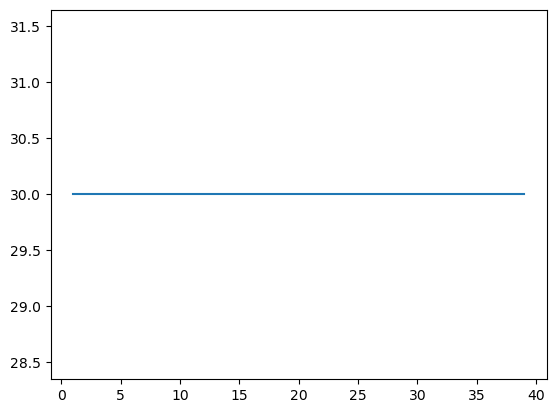

In [114]:
num_keyframes = [len(x) for x in all_keyframes]
plt.plot(thresholds, num_keyframes)

In [130]:
get_total_frames(sample)

714

In [74]:
sample = "data/MVBench/video/tvqa/frames_fps3_hq/s01e09_seg01_clip_00"
total_frames = get_total_frames(sample)
len_default = len(get_keyframes_ffmpeg(sample, sc_threshold=40, bframes=-1,))
len_zero = len(get_keyframes_ffmpeg(sample, sc_threshold=40, bframes=0))
len_default, len_zero

ffmpeg version 8.0 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/8.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enab

(11, 12)

In [119]:
# Returns all the full paths to the MVBench videos. This includes paths to the tvqa directories which contain single frames
def get_all_video_locations():
    video_extensions = ["mp4", "webm"]
    globs = [os.path.join("data/MVBench/video", '**', f'*.{ext}') for ext in video_extensions]
    
    video_files = [f for g in globs for f in glob.glob(g, recursive=True)]

    # get tvqa dirs
    tvqa_dir = Path("data/MVBench/video/tvqa/frames_fps3_hq")
    frame_dirs = ([f for f in tvqa_dir.iterdir() if f.is_dir()])
    
    return video_files + frame_dirs

In [150]:
video_locations = get_all_video_locations()

In [151]:
video_frame_rates = [get_frame_rate(v) for v in tqdm(video_locations)]
print("Minimum frame rate", min(video_frame_rates))
print("Maximum frame rate", max(video_frame_rates))

  0%|          | 0/3499 [00:00<?, ?it/s]

Minimum frame rate 3.0
Maximum frame rate 60000/1001


In [152]:
video_frame_counts = np.array([get_total_frames(v) for v in tqdm(video_locations)])
print("Minimum frame count", video_frame_counts.min())
print("Maximum frame count", video_frame_counts.max())

  0%|          | 0/3499 [00:00<?, ?it/s]

Minimum frame count 5
Maximum frame count 3477


In [ ]:
def get_ffmpeg_keyframe_indices_for_target_frame_rate(
    path: str,
    video_fr: Fraction,
    target_rate: Fraction,
    compression_ratio: Fraction,
    sc_threshold: int = 40, 
    bframes: int = -1
):
    # Use ceiling so we don't oversample
    min_scene_len = np.ceil(float(video_fr / target_rate))
    max_scene_len = np.ceil(float(video_fr / target_rate * compression_ratio))

    keyframes = get_keyframes_ffmpeg(
    path
    keyint_min=min_scene_len,
    keyint_max=max_scene_len, 
    sc_threshold=sc_threshold 
    bframes=bframes
    )

    return keyframes

In [ ]:
def eval_keyframe_count_by_dir(
    files: list[Path],
    target_rate: Fraction,
    compression_ratio: Fraction,
    sc_thresholds: list,
    bframes: int,
    write_stats: bool = True,
    output_file: str = "kf_stats.csv"
):
    folders_dict = {}
    for file in files:
        if file.parts[3] not in folders_dict:
            folders_dict[file.parts[3]] = []
        folders_dict[file.parts[3]].append(file)

    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["path", "frame_count", "uniform_frames", "key_frames"])
        for folder in folders_dict:
            print(f"===Processing folder {folder}===")
            i = 0
            pbar = tqdm(folders_dict[folder])
            total_frames = 0
            total_frames_saved = 0
            total_keyframes = 0
            total_uniform_frames = 0
            for f in pbar:
                video_fr = get_frame_rate(f)
                    keyframes, kf_count, frame_count = get_ffmpeg_keyframe_indices_for_target_frame_rate(
                        f
                        video_fr,
                        target_rate
                        compression_ratio,
                        sc_threshold, 
                        bframes
                    )
                    if j == 0:
                        total_frames += frame_count
                    total_kfs[sc_threshold] += kf_count
                    # Calculate the number of frames that would be used if we used uniform sampling
                    uniform_sampling = np.floor(frame_count / video_fr * target_rate)
                    total_uniform_frames += uniform_sampling
                    frames_saved = frame_count - uniform_sampling
                    total_frames_saved += frames_saved
                    total_ratio += frame_count / uniform_sampling
                    writer.writerow([str(f), frame_count, uniform_sampling, kf_count])
                    i += 1
                    pbar.set_description(f"Tot frm: {total_frames}, tot kf: {total_keyframes}, tot unif: {total_uniform_frames}, avg frm reduction: {total_frames_saved / i}, avg ratio: {total_ratio / i}")
            print("Finished processing folder")
            print(f"Total frames: {total_frames}, total keyframes: {total_keyframes}, tot uniformly sampled frames: {total_uniform_frames}, avg. frame reduction: {total_frames_saved / i}, avg. frame compression ratio: {total_ratio / i}")

In [264]:
def get_keyframes_ffmpeg_fast(
    path: str, 
    keyint_min: int = 8, 
    keyint_max: int = 24, 
    sc_threshold: int = 40, 
    bframes: int = -1 # -1 is default, libx264 defaults to 3
) -> tuple[list[int], int, int]:
    tmp_file = "ffmpeg/out_fast.h264"
    cmd = None
    p = Path(path)
    if p.is_dir():
        cmd = [
        "ffmpeg", 
        "-framerate", "3", # tvqa videos all are at 3 fps
        "-i", p / "%05d.jpg", 
        "-v", "error",
        "-vf", "scale=trunc(iw/2)*2:trunc(ih/2)*2", # Make sure h/w is even
        "-c:v", "libx264", 
        "-g", str(keyint_max), 
        "-keyint_min", str(keyint_min), 
        "-sc_threshold", str(sc_threshold), 
        "-flags", "+cgop", # Use closed GOP to force frames to reference current 
        "-bf", str(bframes),
        tmp_file,
    ]
    else:
        cmd = [
        "ffmpeg", 
        "-v", "error",
        "-i", str(path), 
        "-c:v", "libx264", 
        "-vf", "scale=trunc(iw/2)*2:trunc(ih/2)*2", # Make sure h/w is even
        "-g", str(keyint_max), 
        "-keyint_min", str(keyint_min), 
        "-sc_threshold", str(sc_threshold), 
        "-flags", "+cgop", # Use closed GOP to force frames to reference current 
        "-bf", str(bframes),
        tmp_file,
    ]
    subprocess.check_call(cmd)
    ffprobe_cmd = [
        "ffprobe",
        "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "frame=pict_type,key_frame",
        "-of", "csv=p=0", 
        tmp_file
    ]

    output = subprocess.check_output(ffprobe_cmd).decode('utf-8')

    lines = output.strip().split('\n')
    idr_indices = []
    frame_count = 0
    idr_count = 0
    for i, line in enumerate(lines):
        line = line.strip(",") # ffmpeg does trailing commas sometimes
        if not line:
            continue
        key_flag, ptype = line.split(',')
        frame_count += 1
        if ptype == 'I' and key_flag == '1':
            idr_indices.append(i)
            idr_count += 1
    os.remove(tmp_file)
    return idr_indices, idr_count, frame_count

def get_keyframes_ffmpeg_pipe(
    path: str, 
    keyint_min: int = 8, 
    keyint_max: int = 24, 
    sc_threshold: int = 40, 
    bframes: int = -1 # -1 is default, libx264 defaults to 3
) -> tuple[list[int], int, int]:
    cmd = None
    p = Path(path)
    if p.is_dir():
        cmd = [
        "ffmpeg", 
        "-preset", "faster",
        "-framerate", "3", # tvqa videos all are at 3 fps
        "-i", p / "%05d.jpg", 
        "-v", "error",
        "-vf", "scale=trunc(iw/2)*2:trunc(ih/2)*2", # Make sure h/w is even
        "-c:v", "libx264", 
        "-g", str(keyint_max), 
        "-keyint_min", str(keyint_min), 
        "-sc_threshold", str(sc_threshold), 
        "-flags", "+cgop", # Use closed GOP to force frames to reference current 
        "-bf", str(bframes),
        "-f", "h264",
        "pipe:1",
    ]
    else:
        cmd = [
        "ffmpeg", 
        "-v", "error",
        "-i", str(path), 
        "-c:v", "libx264", 
        "-preset", "faster",
        "-vf", "scale=trunc(iw/2)*2:trunc(ih/2)*2", # Make sure h/w is even
        "-g", str(keyint_max), 
        "-keyint_min", str(keyint_min), 
        "-sc_threshold", str(sc_threshold), 
        "-flags", "+cgop", # Use closed GOP to force frames to reference current 
        "-bf", str(bframes),
        "-f", "h264",
        "pipe:1",
    ]
    ffmpeg_process = subprocess.Popen(cmd, stdout=subprocess.PIPE)
    ffprobe_cmd = [
        "ffprobe",
        "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "frame=pict_type,key_frame",
        "-of", "csv=p=0", 
        "-"
    ]
    
    output = subprocess.check_output(ffprobe_cmd, stdin=ffmpeg_process.stdout)
    ffmpeg_process.wait()

    lines = output.decode('utf-8').strip().split('\n')
    idr_indices = []
    frame_count = 0
    idr_count = 0
    for i, line in enumerate(lines):
        line = line.strip(",") # ffmpeg does trailing commas sometimes
        if not line:
            continue
        key_flag, ptype = line.split(',')
        frame_count += 1
        if ptype == 'I' and key_flag == '1':
            idr_indices.append(i)
            idr_count += 1
    return idr_indices, idr_count, frame_count

In [251]:
sample = "data/MVBench/video/data0613/star/Charades_v1_480/3XKBC.mp4"
%timeit keyframes, _, _ = get_keyframes_ffmpeg(sample, sc_threshold=200, bframes=0)
%timeit keyframes_fast, _, _ = get_keyframes_ffmpeg_fast(sample, sc_threshold=200, bframes=0)
%timeit keyframes_pipe, _, _ = get_keyframes_ffmpeg_pipe(sample, sc_threshold=200, bframes=0)

assert keyframes_fast == keyframes
assert keyframes_pipe == keyframes

2.97 s ± 58.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.85 s ± 39.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.85 s ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [265]:
%timeit keyframes_pipe, _, _ = get_keyframes_ffmpeg_pipe(sample, sc_threshold=200, bframes=0)


1.3 s ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [266]:
len(keyframes_pipe)

63

In [ ]:
assert keyframes_pipe == keyframes